In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cookie-cats-dataset/cookie_cats.csv


## Form hypotheses
We don't want our approach to be biased; therefore we should form a hypothesis BEFORE looking at data. The end goal is to determine whether the difference between the retention rate of Gate 30 and Gate 40 players is significant after day 1 and after day 7.

Day 1 Retention:
- Null hypothesis ($H_0$): There's no difference in `retention_1` between the 2 groups (Gate 30 and Gate 40) i.e. $p_{gate_{30}}$ = $p_{gate_{40}}$
- Alternate hypothesis ($H_1$): There's a significant difference in `retention_1` between the 2 groups (Gate 30 and Gate 40) i.e. $p_{gate_{30}}$ $\neq$ $p_{gate_{40}}$

Day 7 Retention
- Null hypothesis ($H_0$): There's no difference in `retention_1` between the 2 groups (Gate 30 and Gate 40) i.e. $p_{gate_{30}}$ = $p_{gate_{40}}$
- Alternate hypothesis ($H_1$): There's a significant difference in `retention_1` between the 2 groups (Gate 30 and Gate 40) i.e. $p_{gate_{30}}$ $\neq$ $p_{gate_{40}}$

Number of game rounds
- Null hypothesis ($H_0$): The average number of game rounds is the same between the 2 groups
- Alternate hypothesis ($H_1$): The average number of game rounds is significantly different between the 2 groups

We will proceed with extracting relevant data. We will also consider this whole dataset as a sample and any conclusion from this sample can represent the population (which is the new data coming in later on).

In [2]:
df = pd.read_csv('/kaggle/input/cookie-cats-dataset/cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Data preprocessing

In [4]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [5]:
# check if all user ids are unique
df['userid'].nunique()

90189

All users in the dataset (our sample) are unique

In [6]:
# check for missing values across columns
count = 0
for col in df.columns:
    count = count + df[col].isna().sum()
count

0

There is no NaN values in our dataset since it's been preprocessed and the main focus is to learn how to A/B test our dataset.

### Visualization on the number of game rounds between Gate 30 and Gate 40 players

In [7]:
df.groupby('version').sum_gamerounds.agg(['count', 'median', 'mean', 'std', 'max'])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


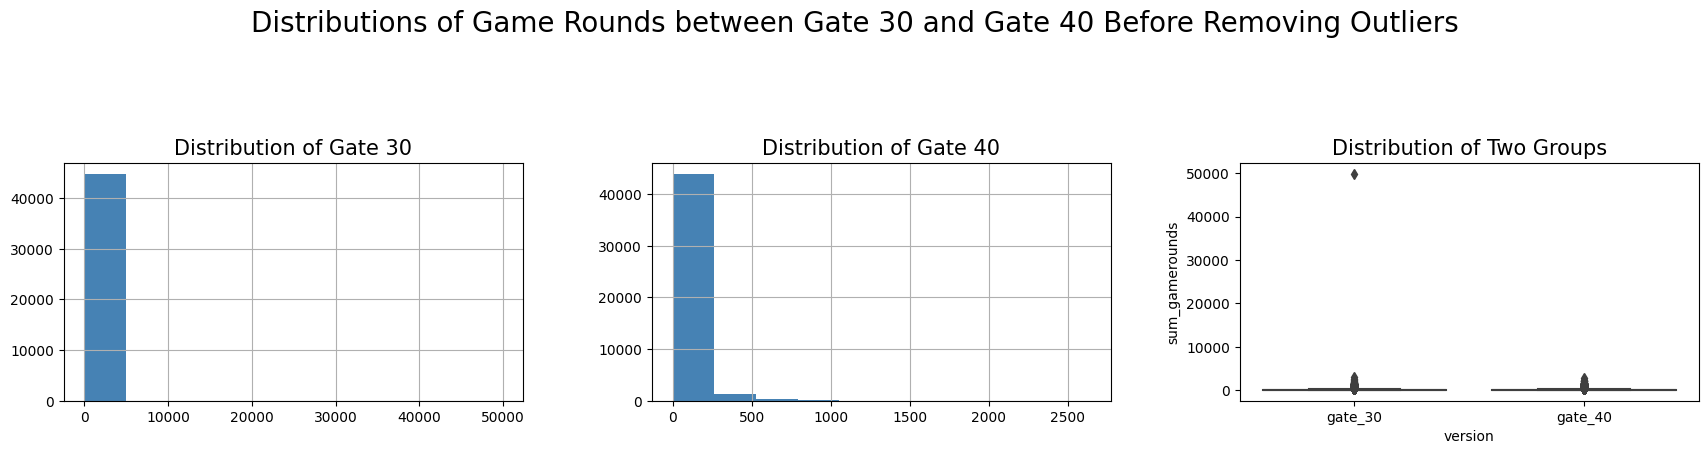

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Distributions of Game Rounds between Gate 30 and Gate 40 Before Removing Outliers", fontsize = 20)
axes[0].set_title("Distribution of Gate 30", fontsize = 15)
axes[1].set_title("Distribution of Gate 40", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

From the distribution of the two groups, we notice that there's an outlier in the number of game rounds played for gate_30. We will check how many of such extreme values are there

In [9]:
df_gate_30 = df[df['version'] == 'gate_30']
df_gate_30[df_gate_30['sum_gamerounds'] > 10000].value_counts().sum()

1

There's only 1 such extreme value where his/her number of play rounds exceeds 10000. We will remove this outlier.

In [10]:
df = df[df.sum_gamerounds < 10000]
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


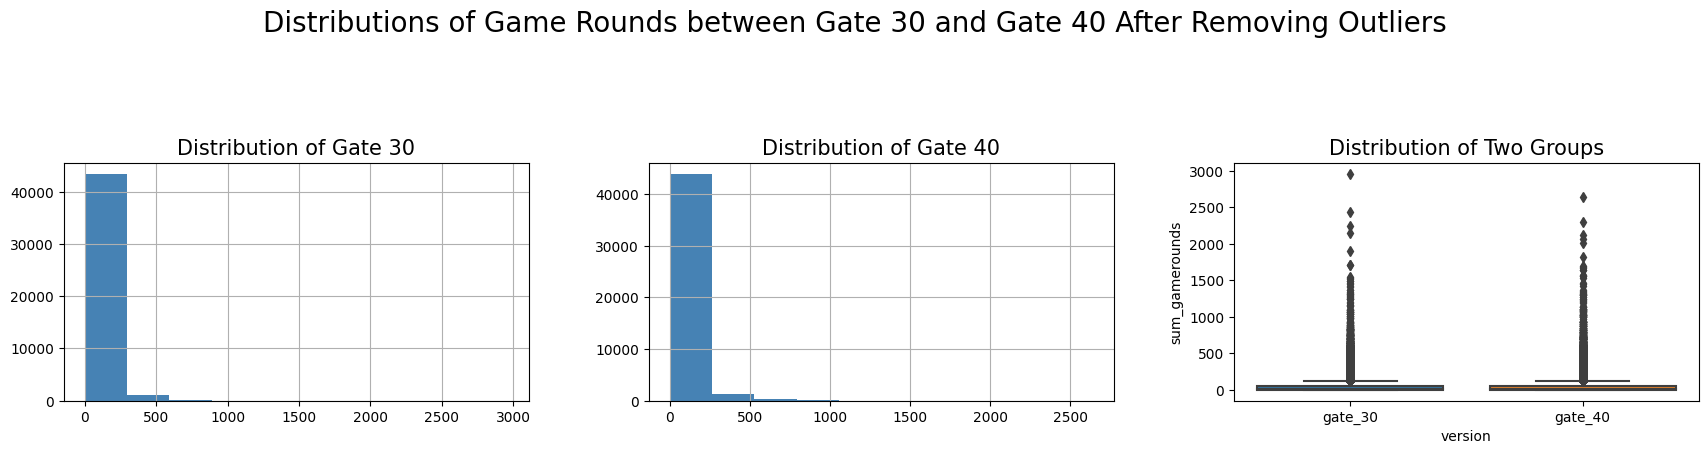

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df[(df.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
df[(df.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])

plt.suptitle("Distributions of Game Rounds between Gate 30 and Gate 40 After Removing Outliers", fontsize = 20)
axes[0].set_title("Distribution of Gate 30", fontsize = 15)
axes[1].set_title("Distribution of Gate 40", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

## Total number of users for each group

In [12]:
gate_30_players = df[df['version'] == 'gate_30'].value_counts().sum()
gate_40_players = df[df['version'] == 'gate_40'].value_counts().sum()

## Hypothesis 1: Difference in `retention_1` rate between the 2 groups

In [13]:
# convert the column retention_1 and retention_7 into binary numerical values (1 for True, 0 for False)
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)

In [14]:
# number of samples of user who's at version gate 30 and retained after day 1
gate_30_retention_1_users = df[df['version'] == 'gate_30']['retention_1'].sum()
gate_40_retention_1_users = df[df['version'] == 'gate_40']['retention_1'].sum()

In [15]:
# retention rate of users after day 1
gate_30_retention_1_rate = gate_30_retention_1_users / gate_30_players
gate_40_retention_1_rate = gate_40_retention_1_users / gate_40_players

Since our goal for this hypothesis is to measure the difference between the proportions of retention rate between Gate 30 and Gate 40, so the appropriate statistical test is the **Two-proportion Z-test**.

In [16]:
# Two-proportion Z-test for retention 1 between the 2 groups
z_stat_1, p_value_1 = proportions_ztest([gate_30_retention_1_users, gate_40_retention_1_users], [gate_30_players, gate_40_players])

# extract the Z test statistic and its p-value
print(f"Z-statistic (Day 1): {z_stat_1}\nP-value (Day 1): {p_value_1}")

Z-statistic (Day 1): 1.787103509763628
P-value (Day 1): 0.0739207603418346


### Is the result statistically significant (Day 1 retention)?
We will follow the convention of using a 95% confidence interval to determine whether this result is statistically significant. For a 95% confidence interval, the standard significance level $\alpha$ is 0.05. Since our calculated p-value is greater than 0.05, we failed to reject the null hypothesis 

### Is the result practically significant (Day 1 retention)?
Since our result is not statistically significant (such a difference was only due to random chance), it's very hard to say that the result is practically significant since we can't be confident that the observed difference is even real. However, we can still try to test whether it's practically significant. We will implement Cohen's h, which is used to determine practical significance between two proportions (Gate 30 and Gate 40 retention rate after Day 1).

In [17]:
def cohen_h(p1, p2):
    '''
        Purpose:
            Compute Cohen's h for two proportions
            
        Parameters:
            p1: proportion of samples in group 1 p2: proportion of samples in group 2
            
        Returns:
            Cohen's h value
    '''
    # handle error if proportions are not within the range [0, 1]
    if not (0 <= p1 <= 1) or not (0 <= p2 <= 1):
        raise ValueError("Proportions must be between 0 and 1")
    
    # compute Cohen's h
    h = 2 * np.arcsin(np.sqrt(p1)) - 2 * np.arcsin(np.sqrt(p2))
    return h

In [18]:
# calculate cohen's h for proportions of retained users after day 1
h_value_day_1 = cohen_h(gate_30_retention_1_rate, gate_40_retention_1_rate)
print(f"Cohen's h (Retention 1): {h_value_day_1:.4f}")

Cohen's h (Retention 1): 0.0119


As expected, our Cohen's h for retention 1 is very small and indicates a very small effect size. This suggests that the difference in retention rates between the two groups is so small that it's likely to be of minimal practical significance. In summary, the difference in retention rates between Gate 30 and Gate 40 players after day 1 is both non-statistically and non-practically significant. We will proceed with retention after day 7 hypothesis.

## Hypothesis 2: Difference in `retention_7` rate between the 2 groups

In [19]:
# number of samples of user who's at version gate 30 and retained after day 1
gate_30_retention_7_users = df[df['version'] == 'gate_30']['retention_7'].sum()
gate_40_retention_7_users = df[df['version'] == 'gate_40']['retention_7'].sum()

In [20]:
# retention rate of users after day 1
gate_30_retention_7_rate = gate_30_retention_7_users / gate_30_players
gate_40_retention_7_rate = gate_40_retention_7_users / gate_40_players

In [21]:
gate_40_retention_7_rate

0.18200004396667327

Similarly, the statistical test we will perform for this hypothesis is the **Two-proportion Z-test**

In [22]:
# Two-proportion Z-test for retention 7 between the 2 groups
z_stat_7, p_value_7 = proportions_ztest([gate_30_retention_7_users, gate_40_retention_7_users], [gate_30_players, gate_40_players])

# extract the Z test statistic and its p-value
print(f"Z-statistic (Day 7): {z_stat_7}\nP-value (Day 7): {p_value_7}")

Z-statistic (Day 7): 3.1574100858819936
P-value (Day 7): 0.0015917731773993442


To test the significance, we can follow 2 common ways:
1. Compare the test statistic to the critical value for your confidence interval
- We have to compute the critical value
2. Compare the p-value to the significance level ($\alpha = 0.05$) for a 95% confidence interval

We will proceed with the second way.

### Is the result statistically significant (Day 7 retention)?
For a 95% confidence interval, the significance level is $\alpha = 0.05$. Since our p-value is 0.001 < $\alpha$, we reject the null hypothesis. In other words, the difference between the retention rates after day 7 of Gate 30 and Gate 40 players is statistically significant, and this happened not due to random chance alone.

### Is the result practically significant (Day 7 retention)?
Even though the result is statistically significant, it may not be large enough to be of practical importance. Practical significance focuses on the effect size—how large the difference is and whether this difference matters in a real-world context. Therefore, we need to apply Cohen's h again to determine the practical significance between 2 proportions.

In [23]:
h_value_day_7 = cohen_h(gate_30_retention_7_rate, gate_40_retention_7_rate)
print(f"Cohen's h (Retention 7): {h_value_day_7:.4f}")

Cohen's h (Retention 7): 0.0210


Again, our Cohen's h value for day 7 retention has an extremely small effect. The difference between 2 proportions is negligible in practical importance. In summary, the result for day 7 retention is statistically significant but not enough for practical significance.